1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Segment 0 identified as Writer 0 and saved to writer_0\segment_0.png
Segment 1 identified as Writer 0 and saved to writer_0\segment_1.png
Segment 2 identified as Writer 1 and saved to writer_1\segment_2.png
Segment 3 identified as Writer 0 and saved to writer_0\segment_3.png
Segment 4 identified as Writer 1 and sa

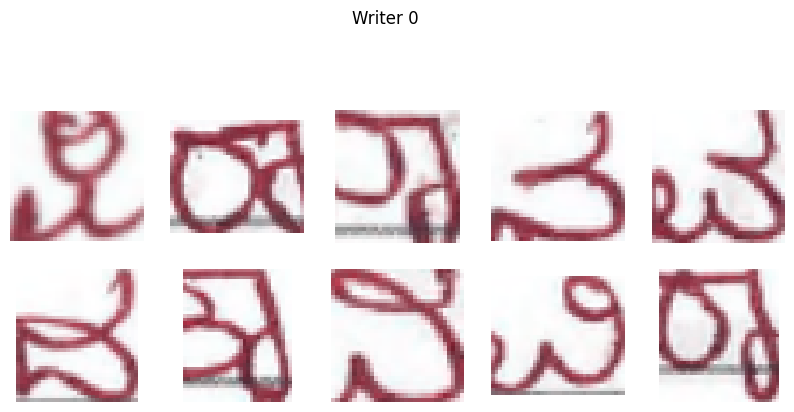

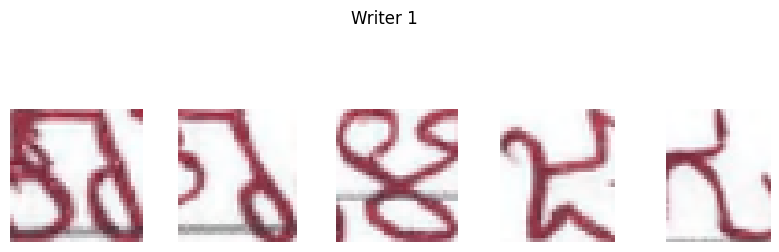

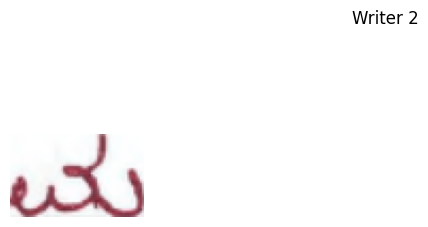

In [ ]:
import cv2
import numpy as np
import os
import pytesseract
from tensorflow.keras.models import load_model
from pdf2image import convert_from_path
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Kannada OCR model
ocr_model = load_model('D:/Projects/ocr/kannada_ocr_model.h5')

# Function to apply OCR to an image segment
def apply_ocr_to_segment(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Ensure grayscale
    resized_img = cv2.resize(gray, (32, 32))
    resized_img = resized_img.astype('float32') / 255
    resized_img = np.expand_dims(resized_img, axis=-1)
    resized_img = np.expand_dims(resized_img, axis=0)

    prediction = ocr_model.predict(resized_img)
    predicted_text = np.argmax(prediction, axis=-1)
    return predicted_text

# Function forimage preprocessing
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Use adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 30)
    return thresh

# Function to extract handwriting segments from a PDF
def extract_handwriting_from_pdf(pdf_path):
    images = convert_from_path(pdf_path)
    handwriting_segments = []

    for page in images:
        img = np.array(page)
        thresh = preprocess_image(img)

        # Find contours of the handwriting segments
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > 30 and h > 30:
                handwriting_segment = img[y:y+h, x:x+w]
                handwriting_segments.append(handwriting_segment)

    return handwriting_segments

# Function to calculate stroke features
def calculate_stroke_features(segment):
    gray = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours for stroke width calculation
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    widths = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        widths.append(w)  # Store widths of bounding boxes

    # Calculate average stroke width
    avg_width = np.mean(widths) if widths else 0
    return avg_width

# Function to identify writers by clustering handwriting style
def identify_writers(segments):
    feature_vectors = []

    for segment in segments:
        ocr_output = apply_ocr_to_segment(segment)
        avg_width = calculate_stroke_features(segment)
        feature_vector = [len(ocr_output), avg_width]
        feature_vectors.append(feature_vector)

    # Clustering using KMeans to identify different writers
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(feature_vectors)

    return kmeans.labels_

# Main process function
def process_pdf_for_writer_identification(pdf_path):
    handwriting_segments = extract_handwriting_from_pdf(pdf_path)
    writer_labels = identify_writers(handwriting_segments)

    for i, segment in enumerate(handwriting_segments):
        writer_id = writer_labels[i]
        writer_dir = f'writer_{writer_id}'
        os.makedirs(writer_dir, exist_ok=True)

        img_path = os.path.join(writer_dir, f'segment_{i}.png')
        cv2.imwrite(img_path, segment)
        print(f'Segment {i} identified as Writer {writer_id} and saved to {img_path}')

    for writer_id in np.unique(writer_labels):
        writer_segments = [handwriting_segments[i] for i in range(len(writer_labels)) if writer_labels[i] == writer_id]
        plt.figure(figsize=(10, 10))
        for j, seg in enumerate(writer_segments[:10]):
            plt.subplot(5, 5, j+1)
            plt.imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))
            plt.axis('off')
        plt.suptitle(f'Writer {writer_id}')
        plt.show()

pdf_path = 'D:/Projects/ocr/kannada_writer.pdf'
process_pdf_for_writer_identification(pdf_path)
